In [1]:
sc.setLogLevel("ERROR")

In [2]:
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer

In [3]:
# read parquet files
hi_train_80 = spark.read.parquet("gs://st446-final-zqh/train_80.parquet")
hi_test_80 = spark.read.parquet("gs://st446-final-zqh/test_80.parquet")

In [4]:
hi_train_80.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+
|0x795230e4ae1665b...|10228574083093215...|   5.0|       4.3|           448|  55017|        131|            1|              826|
|0x7954dad02312acc...|10244408222660792...|   4.0|       4.3|           448|  58783|       3495|            0|           225133|
|0x7c008a4a7a91ecb...|10697585092394703...|   5.0|       4.4|           338| 168406|      11362|            1|           799688|
|0x7c0063611f2afc7...|10406701294353270...|   3.0|       3.9|           108|  98279|       5426|            0|           387144|
|0x79540dec43b7e0e...|10996193821587499...|   4.0|       4.7|           354| 240502|       1626| 

In [5]:
hi_train_80.count()

898153

In [6]:
hi_test_80.count()

99795

In [7]:
def grid_search(train_data, test_data):
    best_rmse = float("inf")
    best_model = None
    best_predictions = None
    best_rank = 0
    best_regParam = 0
    best_maxIter = 0
    for rank in [60]:
        for regParam in [0.1]:
            for maxIter in [20]:
                als = ALS(rank=rank, maxIter=maxIter, regParam=regParam, userCol="user_id", itemCol="business_id", ratingCol="rating_binary", coldStartStrategy="drop")
                model = als.fit(train_data)
                predictions = model.transform(test_data)
                evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating_binary", predictionCol="prediction")
                rmse = evaluator.evaluate(predictions)
                if rmse < best_rmse:
                    best_rmse = rmse
                    best_model = model
                    best_predictions = predictions
                    best_rank = rank
                    best_regParam = regParam
                    best_maxIter = maxIter
                print(f"rank = {rank}, regParam = {regParam}, maxIter = {maxIter}, RMSE = {rmse}")
    return best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter

In [ ]:
best_model,best_rmse,best_predictions,best_rank,best_regParam,best_maxIter = grid_search(hi_train_80, hi_test_80)
print("The best rank is: ", best_rank)
print("The best regParam is: ", best_regParam)
print("The best maxIter is: ", best_maxIter)
print("The best rmse is: ", best_rmse)

rank = 60, regParam = 0.1, maxIter = 20, RMSE = 0.4741790054809077
The best rank is:  60
The best regParam is:  0.1
The best maxIter is:  20
The best rmse is:  0.4741790054809077


In [9]:
best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+
|0x79524b43746eaaa...|10509491739713613...|   5.0|       4.2|             8| 122970|        471|            1|            27499|0.13330565|
|0x79524b44f58d64a...|10409200022032398...|   5.0|       4.2|             8|  98890|        496|            1|            28316|0.28099874|
|0x79524b44f58d64a...|11412730726641110...|   5.0|       4.2|             8| 341954|        496|            1|            28320|0.07604164|
|0x79524bb443e4a93...|10248471344505240...|   5.0|       5.0|           318|  59785|        833|            1|            48059|       0.0|
|0x79524bb443e4a93..

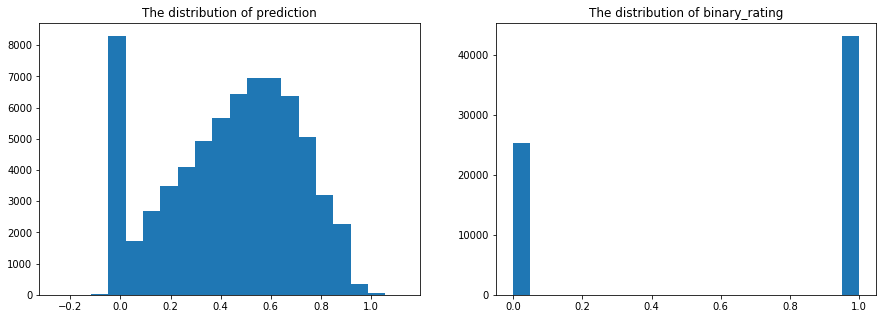

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

best_predictions_pd = best_predictions.toPandas()

# draw the ditrbution of prediction column
axs[0].hist(best_predictions_pd["prediction"], bins=20)
axs[0].set_title("The distribution of prediction")

# draw the ditrbution of rating column
axs[1].hist(best_predictions_pd["rating_binary"], bins=20)
axs[1].set_title("The distribution of binary_rating")

plt.show()

In [12]:
from pyspark.sql.functions import when, col

# define a function to evaluate the model
def evaluate_model(predictions):
    # calculate TP, FP, TN, FN
    TP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 1)).count()
    FP = predictions.filter((col('prediction_binary') == 1) & (col('rating_binary') == 0)).count()
    TN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 0)).count()
    FN = predictions.filter((col('prediction_binary') == 0) & (col('rating_binary') == 1)).count()

    # calculate Precision, Recall, F1-Score
    precision = TP / (TP + FP) if (TP + FP) else 0
    recall = TP / (TP + FN) if (TP + FN) else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) else 0

    # calculate accuracy
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate Specificity
    specificity = TN / (TN + FP) if (TN + FP) else 0

    return accuracy, precision, recall, f1_score, specificity

In [13]:
best_predictions = best_predictions.withColumn('prediction_binary', when(col('prediction') > 0, 1).otherwise(0))
accuracy, precision, recall, f1_score, specificity = evaluate_model(best_predictions)
print("The accuracy of the ALS model is:", accuracy)
print("The precision of the ALS model is:", precision)
print("The recall of the ALS model is:", recall)
print("The f1_score of the ALS model is:", f1_score)
print("The specificity of the ALS model is:", specificity)

The accuracy of the ALS model is: 0.6567212109711417
The precision of the ALS model is: 0.6622717046056115
The recall of the ALS model is: 0.9280862408716819
The f1_score of the ALS model is: 0.7729646756707181
The specificity of the ALS model is: 0.19537285196279364


In [14]:
# normalize the 'prediction' into 0-1

max_prediction = best_predictions.agg({"prediction": "max"}).collect()[0][0]
min_prediction = best_predictions.agg({"prediction": "min"}).collect()[0][0]

best_predictions = best_predictions.withColumn("probability", (best_predictions["prediction"] - min_prediction) / (max_prediction - min_prediction))

best_predictions.show(5)

+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|            business|                user|rating|avg_rating|num_of_reviews|user_id|business_id|rating_binary|__index_level_0__|prediction|prediction_binary|        probability|
+--------------------+--------------------+------+----------+--------------+-------+-----------+-------------+-----------------+----------+-----------------+-------------------+
|0x79524b43746eaaa...|10509491739713613...|   5.0|       4.2|             8| 122970|        471|            1|            27499|0.13330565|                1|0.28105879737204204|
|0x79524b44f58d64a...|10409200022032398...|   5.0|       4.2|             8|  98890|        496|            1|            28316|0.28099874|                1|0.38804505239808923|
|0x79524b44f58d64a...|11412730726641110...|   5.0|       4.2|             8| 341954|        496|            1|

In [15]:
# draw the precision-recall curve and ROC curve
from sklearn.metrics import precision_recall_curve, roc_curve, auc

best_predictions_pd = best_predictions.toPandas()

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the roc curve
fpr, tpr, _ = roc_curve(best_predictions_pd["rating_binary"], best_predictions_pd["probability"])

# calculate the auc
auc_score = auc(fpr, tpr)
print(auc_score)

0.767695837439994


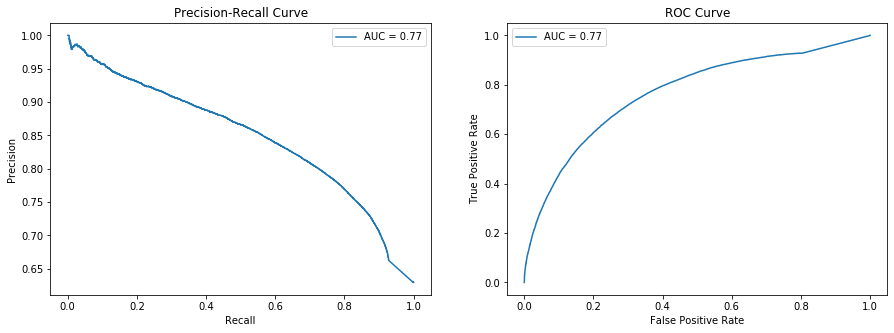

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# draw the precision-recall curve
axs[0].plot(recall, precision, label="AUC = {:.2f}".format(auc_score))
axs[0].set_xlabel("Recall")
axs[0].set_ylabel("Precision")
axs[0].set_title("Precision-Recall Curve")
axs[0].legend()

# draw the roc curve
axs[1].plot(fpr, tpr, label="AUC = {:.2f}".format(auc_score))
axs[1].set_xlabel("False Positive Rate")
axs[1].set_ylabel("True Positive Rate")
axs[1].set_title("ROC Curve")
axs[1].legend()

plt.show()